# Style T-SNE
- Pretrained ResNet50
- [T-SNE Visulization](https://www.youtube.com/watch?v=EMD106bB2vY)

## 1. Settings
### 1) Import libraries for model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable

### 2) Import libraries for T-SNE

In [2]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### 3) Hyperparameter

In [3]:
image_size = 256

## 2. Data
### 1) Input Pipeline

In [4]:
style_dir = "./image/"
data = dset.ImageFolder(style_dir,transform= transforms.Compose([
        transforms.Scale(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        ]))

print(data.class_to_idx)
img_list = []
for i in data.imgs:
    img_list.append(i[0])

{'black_white': 0, 'dark': 1, 'else': 2, 'fluorescence ': 3, 'high_contrast': 4, 'light': 5, 'light_normal': 6, 'low_contrast': 7, 'pastel': 8, 'plain': 9, 'primary_color': 10, 'splendid': 11}


## 3. Model & Loss Function
### 1) Resnet

In [5]:
resnet = models.resnet50(pretrained=True)

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet,self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        #self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        #self.layer5 = nn.Sequential(*list(resnet.children())[7:8])

    def forward(self,x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        #out_4 = self.layer4(out_3)
        #out_5 = self.layer5(out_4)

        return out_0, out_1, out_2, out_3, # out_4, out_5

### 3) Gram Matrix Function

In [6]:
# gram matrix
# [batch,channel,height,width] -> [b,c,h*w]
# [b,c,h*w] x [b,h*w,c] = [b,c,c]

class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        return G

### 4) Gram Matrix Loss

In [7]:
# gram matrix mean squared error

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

### 5) Model on GPU

In [8]:
# model is not updated so .requires_grad = False

resnet = Resnet().cuda()
for param in resnet.parameters():
    param.requires_grad = False

## 4. Extract Features

In [9]:
style_weight = [1/n**2 for n in [64,64,256,512]] # 512,1024,2048

total_arr = []
label_arr = []
for idx,(image,label) in enumerate(data):
    i = Variable(image).cuda()
    i = i.view(-1,i.size()[0],i.size()[1],i.size()[2])

    style_target = list(GramMatrix().cuda()(i) for i in resnet(i))
    arr = torch.cat([style_target[0].view(-1),style_target[1].view(-1),style_target[2].view(-1),style_target[3].view(-1)],0)
    gram = arr.cpu().data.numpy().reshape(1,-1)
    total_arr.append(gram.reshape(-1))
    label_arr.append(label)

    #print(idx)

print(label_arr)

[0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 5, 5, 5, 5, 6, 7, 8, 8, 9, 10, 10, 10, 11]


## 5. Apply T-SNE

In [10]:
print("\n------Starting TSNE------\n")

model = TSNE(n_components=2, init='pca',random_state=0)
result = model.fit_transform(total_arr)

print("\n------TSNE Done------\n")


------Starting TSNE------


------TSNE Done------



## 6. Visualize Result
### 1) Scatter plot function

In [11]:
def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

### 2) Plot Images


------Starting to plot------

0/133
1/133
2/133
3/133
4/133
5/133
6/133
7/133
8/133
9/133
10/133
11/133
12/133
13/133
14/133
15/133
16/133
17/133
18/133
19/133
20/133
21/133
22/133
23/133
24/133
25/133
26/133
27/133
28/133
29/133
30/133
31/133
32/133
33/133
34/133
35/133
36/133
37/133
38/133
39/133
40/133
41/133
42/133
43/133
44/133
45/133
46/133
47/133
48/133
49/133
50/133
51/133
52/133
53/133
54/133
55/133
56/133
57/133
58/133
59/133
60/133
61/133
62/133
63/133
64/133
65/133
66/133
67/133
68/133
69/133
70/133
71/133
72/133
73/133
74/133
75/133
76/133
77/133
78/133
79/133
80/133
81/133
82/133
83/133
84/133
85/133
86/133
87/133
88/133
89/133
90/133
91/133
92/133
93/133
94/133
95/133
96/133
97/133
98/133
99/133
100/133
101/133
102/133
103/133
104/133
105/133
106/133
107/133
108/133
109/133
110/133
111/133
112/133
113/133
114/133
115/133
116/133
117/133
118/133
119/133
120/133
121/133
122/133
123/133
124/133
125/133
126/133
127/133
128/133
129/133
130/133
131/133
132/133


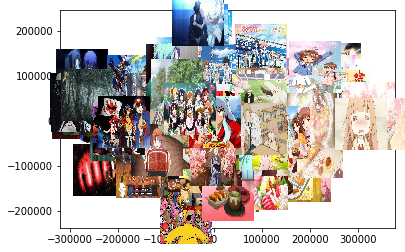

In [12]:
print("\n------Starting to plot------\n")

for i in range(len(result)):
    print("{}/{}".format(i,len(result)))
    img_path = img_list[i]
    imscatter(result[i,0],result[i,1], image=img_path,zoom=0.2)

plt.show()